In [1]:
# 第八章 CNN
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = './data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [5]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [6]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [8]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv, conv.weight.shape, conv.bias.shape

(Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)),
 torch.Size([16, 3, 3, 3]),
 torch.Size([16]))

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

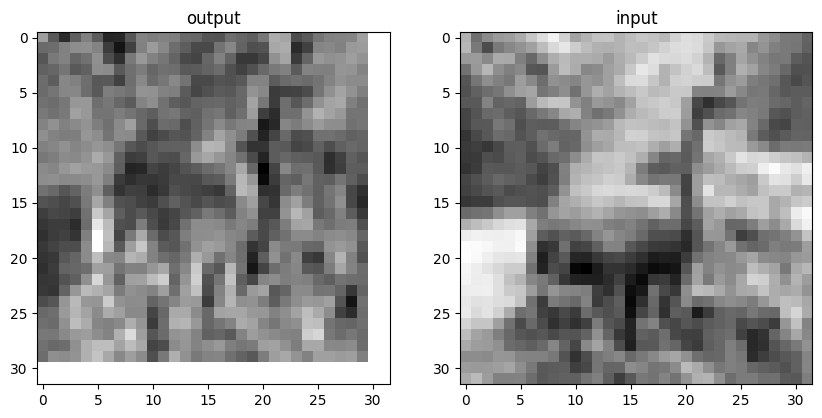

In [10]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

In [11]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [12]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

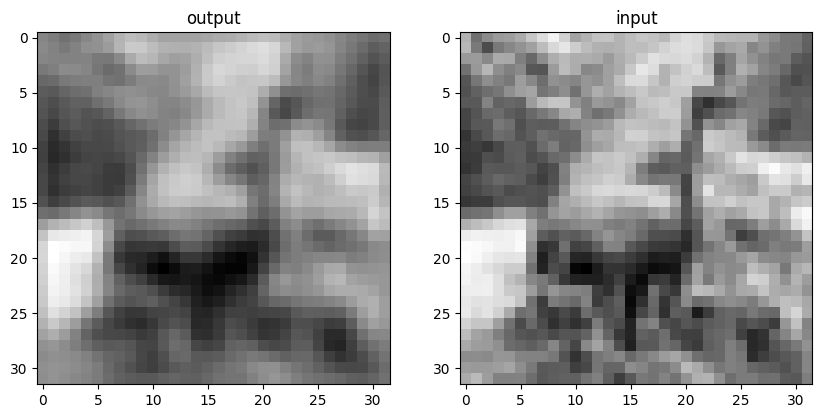

In [13]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [14]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

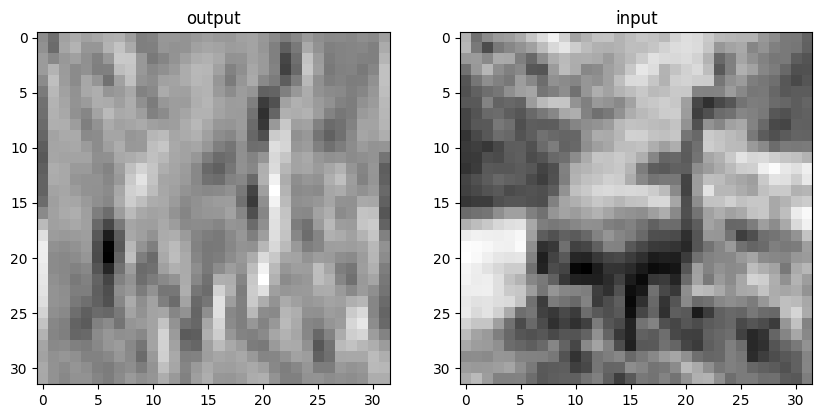

In [15]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

In [16]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [17]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),   # 传入前需要展平，这里没展平，所以报错
            nn.Tanh(),
            nn.Linear(32, 2))

In [18]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [19]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>     展平
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [21]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [22]:
model(img[None])    # 就不报错了

tensor([[-0.1937,  0.2691]], grad_fn=<AddmmBackward0>)

In [23]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [25]:
model = Net()
model, model(img.unsqueeze(0))

(Net(
   (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (fc1): Linear(in_features=512, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=2, bias=True)
 ),
 tensor([[-0.1350, -0.0096]], grad_fn=<AddmmBackward0>))

In [26]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [29]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        loss_val = .0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        for imgs_val,labels_val in val_loader:
            imgs_val = imgs_val.to(device)
            labels_val = labels_val.to(device)
            outputs_val = model(imgs_val)
            loss_val_batch = loss_fn(outputs_val, labels_val)
            loss_val += loss_val_batch.item()


        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}, Val loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader), loss_val / len(val_loader)))

In [33]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)

2023-07-26 16:36:32.837065 Epoch 1, Training loss 0.5742714579697628, Val loss 0.49270721804350615
2023-07-26 16:36:36.971287 Epoch 10, Training loss 0.3402191987083216, Val loss 0.3453865507617593
2023-07-26 16:36:41.388477 Epoch 20, Training loss 0.2974901187002279, Val loss 0.31665819557383657
2023-07-26 16:36:45.945447 Epoch 30, Training loss 0.2712953682917698, Val loss 0.288325066678226
2023-07-26 16:36:51.044216 Epoch 40, Training loss 0.25249449386718165, Val loss 0.2813241705298424
2023-07-26 16:36:56.376503 Epoch 50, Training loss 0.23544310607538102, Val loss 0.2827977300621569
2023-07-26 16:37:01.718298 Epoch 60, Training loss 0.22010605203308117, Val loss 0.2665090155787766
2023-07-26 16:37:06.713433 Epoch 70, Training loss 0.20481181661983963, Val loss 0.2854926371946931
2023-07-26 16:37:11.384690 Epoch 80, Training loss 0.1893415581553605, Val loss 0.26040240097790956
2023-07-26 16:37:16.305943 Epoch 90, Training loss 0.17571092624763016, Val loss 0.2718874332495034
2023

In [31]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = NetWidth().to(device)

In [34]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
model = NetWidth().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)

2023-07-26 16:37:22.325992 Epoch 1, Training loss 0.5373326936724839, Val loss 0.4701564097777009
2023-07-26 16:37:27.150807 Epoch 10, Training loss 0.3128995291746346, Val loss 0.3208216247148812
2023-07-26 16:37:32.105969 Epoch 20, Training loss 0.2753521110981133, Val loss 0.293071695137769
2023-07-26 16:37:36.959280 Epoch 30, Training loss 0.2463438183923436, Val loss 0.2758124303072691
2023-07-26 16:37:41.810067 Epoch 40, Training loss 0.21854386711196536, Val loss 0.27301512099802494
2023-07-26 16:37:46.692708 Epoch 50, Training loss 0.19487953447042758, Val loss 0.30866790330037475
2023-07-26 16:37:51.542442 Epoch 60, Training loss 0.16973349963356354, Val loss 0.2635233108885586
2023-07-26 16:37:56.367873 Epoch 70, Training loss 0.1490319888493058, Val loss 0.3550635939463973
2023-07-26 16:38:01.257225 Epoch 80, Training loss 0.12938258502703565, Val loss 0.2741622324101627
2023-07-26 16:38:06.103990 Epoch 90, Training loss 0.10909753295171792, Val loss 0.3394785854034126
2023-

In [35]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        loss_val = 0.
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

        with torch.no_grad():
            for imgs_val,labels_val in val_loader:
                imgs_val = imgs_val.to(device)
                labels_val = labels_val.to(device)
                outputs_val = model(imgs_val)
                loss_val_batch = loss_fn(outputs_val, labels_val)
                loss_val += loss_val_batch.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {} Val loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader), loss_val / len(val_loader)))


In [36]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
model = NetWidth().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)

2023-07-26 16:47:11.452743 Epoch 1, Training loss 0.584889171799277 Val loss 0.4798598447814584
2023-07-26 16:47:18.449273 Epoch 10, Training loss 0.3435912340120145 Val loss 0.3204282517544925
2023-07-26 16:47:25.888095 Epoch 20, Training loss 0.29855536873553207 Val loss 0.3090157900005579
2023-07-26 16:47:33.402882 Epoch 30, Training loss 0.273212138919314 Val loss 0.2950283223763108
2023-07-26 16:47:40.806275 Epoch 40, Training loss 0.24957169241206661 Val loss 0.28000630252063274
2023-07-26 16:47:48.219430 Epoch 50, Training loss 0.23029248463879726 Val loss 0.29823357705026865
2023-07-26 16:47:55.708228 Epoch 60, Training loss 0.21546339642280227 Val loss 0.2714069113135338
2023-07-26 16:48:03.129802 Epoch 70, Training loss 0.20275874388445714 Val loss 0.42658416740596294
2023-07-26 16:48:10.715991 Epoch 80, Training loss 0.18353710147985228 Val loss 0.26154622295871377
2023-07-26 16:48:18.184947 Epoch 90, Training loss 0.1732284097345012 Val loss 0.2936061853542924
2023-07-26 16

In [37]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [39]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)

2023-07-26 16:52:59.229342 Epoch 1, Training loss 0.5564623175153307, Val loss 0.49743446707725525
2023-07-26 16:53:03.982727 Epoch 10, Training loss 0.3797512005089195, Val loss 0.3786087119951844
2023-07-26 16:53:09.237919 Epoch 20, Training loss 0.3509374035961309, Val loss 0.36257156543433666
2023-07-26 16:53:14.429446 Epoch 30, Training loss 0.3319043005537835, Val loss 0.3474232703447342
2023-07-26 16:53:19.627103 Epoch 40, Training loss 0.315967361923236, Val loss 0.33613417157903314
2023-07-26 16:53:24.839549 Epoch 50, Training loss 0.2982974065716859, Val loss 0.31884683575481176
2023-07-26 16:53:30.099405 Epoch 60, Training loss 0.2859638746187186, Val loss 0.33683737367391586
2023-07-26 16:53:35.313817 Epoch 70, Training loss 0.27554004131608706, Val loss 0.3198329978622496
2023-07-26 16:53:40.501324 Epoch 80, Training loss 0.25578484000863544, Val loss 0.29932820005342364
2023-07-26 16:53:45.684595 Epoch 90, Training loss 0.24945691783147253, Val loss 0.31745970249176025
20

In [40]:
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.90
Accuracy val: 0.88


In [41]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [43]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2023-07-26 16:55:48.182766 Epoch 1, Training loss 0.4812704601864906, Val loss 0.4093932779505849
2023-07-26 16:55:53.406342 Epoch 10, Training loss 0.26701269578781855, Val loss 0.3081183051690459
2023-07-26 16:55:59.243853 Epoch 20, Training loss 0.21423768048073835, Val loss 0.7388305999338627
2023-07-26 16:56:05.044956 Epoch 30, Training loss 0.17048636415771617, Val loss 0.33616873528808355
2023-07-26 16:56:10.871531 Epoch 40, Training loss 0.13510049521258682, Val loss 0.3094643261283636
2023-07-26 16:56:16.714039 Epoch 50, Training loss 0.10616368264149709, Val loss 0.3234216566197574
2023-07-26 16:56:22.889814 Epoch 60, Training loss 0.08171648414698755, Val loss 0.3369806483387947
2023-07-26 16:56:29.310367 Epoch 70, Training loss 0.06268960059543324, Val loss 0.3490608483552933
2023-07-26 16:56:35.728936 Epoch 80, Training loss 0.04463317510404974, Val loss 0.44138636579737067
2023-07-26 16:56:42.146887 Epoch 90, Training loss 0.03247298237387162, Val loss 0.43151599704287946

In [44]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [45]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2023-07-26 16:58:00.442332 Epoch 1, Training loss 0.645632433663508, Val loss 0.5738021600991488
2023-07-26 16:58:05.391062 Epoch 10, Training loss 0.32685462095934875, Val loss 0.48891421407461166
2023-07-26 16:58:10.564888 Epoch 20, Training loss 0.2781329034430206, Val loss 0.27912035305052996
2023-07-26 16:58:16.213473 Epoch 30, Training loss 0.2419341894661545, Val loss 0.3097879854030907
2023-07-26 16:58:21.929992 Epoch 40, Training loss 0.2131737895357381, Val loss 0.2643292983993888
2023-07-26 16:58:27.790998 Epoch 50, Training loss 0.1885635645431318, Val loss 0.3675427110865712
2023-07-26 16:58:34.249995 Epoch 60, Training loss 0.17038338261235292, Val loss 0.2757118835579604
2023-07-26 16:58:40.711006 Epoch 70, Training loss 0.14549141768722018, Val loss 0.35664197988808155
2023-07-26 16:58:47.166129 Epoch 80, Training loss 0.13140351957623747, Val loss 0.26579861994832754
2023-07-26 16:58:53.688502 Epoch 90, Training loss 0.10420651604557872, Val loss 0.30175769003108144
20

In [46]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [47]:
model = NetResDeep(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2023-07-26 16:59:33.409658 Epoch 1, Training loss 0.4895471681834786, Val loss 0.4331396920606494
2023-07-26 16:59:47.549949 Epoch 10, Training loss 0.21885523769506224, Val loss 0.5534786880016327
2023-07-26 17:00:03.307164 Epoch 20, Training loss 0.12034062557159715, Val loss 0.390592522919178
2023-07-26 17:00:17.850041 Epoch 30, Training loss 0.05147325507347371, Val loss 0.3501037445385009
2023-07-26 17:00:32.312273 Epoch 40, Training loss 0.14268437197882752, Val loss 0.3371687273029238
2023-07-26 17:00:46.758256 Epoch 50, Training loss 0.05941997646134655, Val loss 1.4644887633621693
2023-07-26 17:01:02.515525 Epoch 60, Training loss 0.006014637769923611, Val loss 0.542300034314394
2023-07-26 17:01:18.256293 Epoch 70, Training loss 0.0018127407331967275, Val loss 0.687978008762002
2023-07-26 17:01:33.851413 Epoch 80, Training loss 0.10832361799107189, Val loss 0.47960991715081036
2023-07-26 17:01:49.073832 Epoch 90, Training loss 0.050809878805521756, Val loss 0.5068185641430318


In [49]:
# 习题
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [51]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [60]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [61]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18858, [1200, 16, 1152, 8, 16384, 32, 64, 2])

In [62]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        loss_val = .0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        for imgs_val,labels_val in val_loader:
            imgs_val = imgs_val.to(device)
            labels_val = labels_val.to(device)
            outputs_val = model(imgs_val)
            loss_val_batch = loss_fn(outputs_val, labels_val)
            loss_val += loss_val_batch.item()


        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}, Val loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader), loss_val / len(val_loader)))

In [65]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)

2023-07-26 17:26:23.569794 Epoch 1, Training loss 0.6011447002933283, Val loss 0.5316724376752973
2023-07-26 17:26:27.989382 Epoch 10, Training loss 0.33705596948505206, Val loss 0.3437435361556709
2023-07-26 17:26:32.860801 Epoch 20, Training loss 0.30128328435739893, Val loss 0.3302208399400115
2023-07-26 17:26:37.729985 Epoch 30, Training loss 0.27920010999129835, Val loss 0.3024803758598864
2023-07-26 17:26:42.910530 Epoch 40, Training loss 0.2608299761251279, Val loss 0.2896185228601098
2023-07-26 17:26:47.989918 Epoch 50, Training loss 0.24508488837890563, Val loss 0.31148028932511806
2023-07-26 17:26:52.991456 Epoch 60, Training loss 0.22739823926596126, Val loss 0.3355663758702576
2023-07-26 17:26:57.834070 Epoch 70, Training loss 0.21442580389179242, Val loss 0.2730093286372721
2023-07-26 17:27:02.677378 Epoch 80, Training loss 0.2002442487675673, Val loss 0.2704042512923479
2023-07-26 17:27:07.514902 Epoch 90, Training loss 0.188407123539668, Val loss 0.28176979487761855
2023

In [64]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>     展平
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
# 第10章
